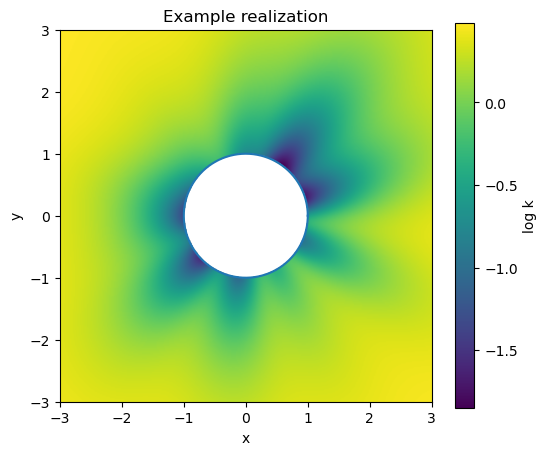

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tunnel_random_field as trf

rng = np.random.default_rng(2025)

# 1) Sample circle fields
theta, A_theta, lambda_theta = trf.sample_tunnel_circle_fields(
    ell_A=0.4, sigma_A_field=1.0, mu_A=-1.0, sigma_A=0.5,
    ell_lambda=1.5, sigma_lambda_field=1.0,
    n_modes_A=10, n_modes_lambda=10,
    rng=rng,
)

# 2) Build one 2D realization
log_k, x, y = trf.build_tunnel_logk_field(theta, A_theta, lambda_theta)

# 3) Plot it
fig, ax = plt.subplots(figsize=(6,5))
trf.plot_logk_field(log_k, x, y, title="Example realization", ax=ax)
plt.show()
